In [17]:
import pandas as pd
import requests
import re
from tqdm import tnrange
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import pickle as pickle
from konlpy.tag import Twitter
from collections import Counter
import konlpy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image 
from wordcloud import WordCloud, ImageColorGenerator # Image 로부터 Color 를 생성(Generate)해내는 객체입니다.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats
%matplotlib inline
import pickle as pickle
from matplotlib import font_manager, rc

In [18]:
content_list = pd.read_pickle("content_list_2.pkl") # 11 개 기업 자소서 내용
counter_token = pd.read_pickle("counter_list_2.pkl") # 11개 기업의 자소서 내용을 불처리하고 토큰화한것 딕트
essay_df = pd.read_pickle("essay_df_2.pkl") #대분류 소분류도 긁어온 크롤링 전체 자료
new_del_word = pd.read_pickle("new_del_word.pkl") # set 불용어 추가한 것들 기업이름은 현대만 들어가있음
position_counter_list = pd.read_pickle("position_counter_list.pkl") # 14개 대분류 직무별 자소서 내용 불처리하고 토근화한것
sort_counter_list = pd.read_pickle("sorted_counter_list_2.pkl") #counter_2 정렬 튜플형식 11개 기업
stopwords = pd.read_json('stopwords-ko.json', encoding = "UTF-8")
my_del_word = pd.read_pickle('my_del_word.pkl') #재실행용
test_df = pd.read_pickle('position_essay_n_nan.pkl') #넌 값 아닌 직무기업정렬 pos작업 안한것
pos_essay_df = pd.read_pickle('pos_essay_df.pkl') #position_essay_n_nan에서 자소서 pos작업하고 str로 각자 묶은것
company_code_dict = pd.read_pickle("company_code_dict.pkl")

## 01. 사용자 정보 입력받기 & 사용자 지원직무와 매치하는 자기소개서 데이터프레임 만들기

In [21]:
position_list = list(pos_essay_df["position_broad"].unique()) #직무목록을 만들어주기(대분류)
show_position_str = '' #빈 str생성

for x in range(len(position_list)):
    show_position_str += ('[' + str(x + 1) + '] ' + position_list[x] + '\n') #숫자와 직무이름 합치기

print("[직무 목록]")
print(show_position_str) # 숫자와 직무이름 합친것을 한줄씩 출력

while True: 
    user_position_num = int(input("직무 목록을 확인하고 지원할 직무의 번호를 입력해주세요.\n")) #int로 안바꿔주면 무한루프에 갇힙니다.
    if (user_position_num - 1) not in range(len(position_list)): #직무번호가 1부터 시작해서 -1을 해줌
        print("잘못 입력하셨습니다. 다시 입력해주세요.")
        continue
    else:
        break
        
user_cv = input("본인의 자기소개서를 입력해주세요.\n")


[직무 목록]
[1] IT·인터넷
[2] 건설
[3] 경영·사무
[4] 교육
[5] 디자인
[6] 마케팅·광고·홍보
[7] 무역·유통
[8] 미디어
[9] 생산·제조
[10] 서비스
[11] 연구개발·설계
[12] 영업·고객상담
[13] 전문·특수직

직무 목록을 확인하고 지원할 직무의 번호를 입력해주세요.
3
본인의 자기소개서를 입력해주세요.
저의 직장 선택의 기준은 타인 혹은 사회에 도움이 되는 일을 하는 것입니다. 재활학교에서 봉사 활동을 하면서 타인과 사회에 기여한다는 것의 소중한 가치를 느꼈습니다. 저의 가르침으로 아이들이 문제를 이해하고 스스로 풀어나가는 모습과 소통이 서툰 아이들이 의사소통을 조금씩 해나가는 모습을 보면서 누군가에게 도움이 되었다는 점에 뿌듯함을 느꼈습니다. 그래서 교육 봉사 활동을 통해 느낀 보람을 바탕으로 교육 서비스 제공을 통해 사회에 기여하는 대학교의 일원이 되고 싶다는 생각을 하게 되었습니다. 서울대학교가 적합한 이유는 제가 지속적인 성장을 추구하는 사람이기 때문입니다. 영어 실력을 향상시키기 위해 군 통역 장교에 도전하였습니다. 아쉽게도 실패하긴 했지만 이를 전화위복의 계기로 삼아 제 2외국어 취득이라는 새로운 목표를 세우고 공부를 하여 1년 반 만에 HSK 6급을 취득하였습니다. 이러한 저의 진취적인 면모가 국내 최고의 대학교로서 성장을 추구하는 서울대학교에 적합하다고 생각합니다. 직장생활에서 가장 중요한 가치는 조직융화력이라 생각합니다. 왜냐하면 직장은 다양한 조직의 부서원과 함께 일하는 곳이기에 조직과 어우러지는 능력이 중요하다고 생각하기 때문입니다. 저는 대학 시절 2개의 동아리 활동과 다양한 프로젝트 활동, 해외 교환학생 생활 등을 통해 다양한 조직에서 다양한 사람들과 협업하며 조직에 융화되는 법을 익혔습니다. 저를 가장 잘 나타내는 키워드는 성실함입니다. 대학 시절 학업에 충실하며 성적 우수 장학금을 수혜하기도 했으며, 마지막 졸업학기에는 유종의 미를 거두기 위해 노력하여 전과목 A+의 성적을 거뒀습니다. 또한

In [20]:
# # 테스트용
# user_cv = """LG CNS가 최근 IT서비스 업계 최초로 IOT 국제표준 인증 ‘oneM2M' 인증과 동시에 'CoAP 프로토콜’ 연동 호환성 인증을 획득했다는 소식을 접했습니다. 학부 졸업프로젝트를 통해서 'CoAP‘ 기술을 처음 접하게 되었고 IOT에 관심을 가지게 되어 비콘 기술을 이용하여 졸업프로젝트를 개발하였습니다. IOT 기술은 미래 산업의 중심으로서 가장 투자해야할 사업이라고 생각하며, 인간의 삶을 더 풍족하게 만들어 줄 수 있다고 생각합니다.저의 꿈은 IOT를 통해 적은 노동력을 사용하여 사람이 더 편리해질 수 있는 기술을 개발하는 것입니다. LG CNS에서는 서버 시설 청소 스마트 로봇, 스마트홈 구현을 위한 셋톱박스 개발 등 IOT 기술 개발을 위해 많은 투자를 하고 있습니다. 사람을 위한 서비스를 개발하는 것에서 저와 같은 길을 가고 있다고 생각합니다. 고객 가치를 최우선적으로 생각하는 LG CNS에서 저의 LG WAY를 구축하고 싶습니다
# CEST 임베디드 연구소에서 주체한 프로젝트 공모전에 친구들과 팀을 이루어 참여한 일이 있었습니다. 주제는 ‘BLE 비콘을 이용한 스마트자전거 군집주행’으로 전기자전거의 현재 위치 좌표와 자전거 간의 거리를 GPS와 비콘의 보정 알고리즘을 통해 측정한 후 군집상에서 자전거의 위치를 휴대폰 어플리케이션에 표시하는 것 입니다. 자전거 간의 거리는 기준 거리에 비해 가까울 시 전기자전거의 속도를 줄이고 거리가 멀어질 때는 속도를 높이는 속도 자동제어 기능을 아두이노에서 전기자전거 신호 제어 알고리즘을 통해 구현하였습니다.
# 프로젝트의 완성 후 성과를 인정받아 3학년 겨울방학에 연구소에서 인턴을 하였습니다. 연구소에서는 지그비 기반 전자가격표시기(ESL) 사업을 중점으로 진행하여 대형마트와 백화점에 납품을 하고 있었습니다. ESL 프로그램의 서버DB 업데이트 및 버그를 테스트하는 업무를 하였으며 그 과정에서 ESL 프로그램의 구조에 대해 자세히 알 수 있었습니다.
# LG CNS에서 새만금간척지에 2022년까지 막대한 투자를 하여 스마트팜을 완공한다는 계획을 알게 되었습니다.
# 농업이란 우리의 삶에서 뗄 수 없는 존재 입니다. 하지만 농업에 종사하는 인구는 점점 감소하고 있으며 노동력이 점점 줄어들고 있기에 스마트팜 기술이 꼭 필요하다고 생각합니다. 저는 LG CNS의 ITP 직무를 맡아 완벽한 스마트팜 시스템을 구축하는데 기여하겠습니다. 나아가 10년 뒤에는 새만금간척지 스마트팜 시스템을 안정화하고 더 확장해서 네덜란드의 ‘애그리포트 A7' 지역과 같은 방대한 스마트팜을 구축하기 위해 노력하겠습니다.
# 그러기 위해선 IOT 기술을 활용한 자동온도조절 시스템과 수분공급 시스템, 재배 정도 분석 시스템 등 스마트팜 자동화에 필요한 기술을 익히겠습니다. 그리고 고객만족도 부분에 아직 미흡한 기술인 수확 및 포장 자동화 기술을 보완하여 스마트팜 분야에서 앞서가는 일등 LG를 만들어 가겠습니다""" # 사용자 자소서내용

In [22]:
user_position = position_list[user_position_num - 1] # 사용자 지원 직무 #인덱스는 0부터인데 직무목록이 1부터로 보여줘서 -1
target_df = pos_essay_df[pos_essay_df["position_broad"] == user_position]  #사용자 직무와 일치하는 자소서 데이터프레임

## 02. 사용자 자기소개서 형태소 및 불용어 처리하기

In [23]:
my_del_word = list(my_del_word) #set타입을 list로 불용어 따로 추가한 모음집
stopwords = list(stopwords) #set타입을 list로
common_del_list = ['되어다','때문','그리고','좋다','자다','없다','같다','싶다','보다', '하다', '있다', '되다', '이다', '돼다', '않다', '그렇다', '아니다', '이렇다', '그렇다', '어떻다']
del_list = stopwords + common_del_list + my_del_word
counter_list = []

def user_cv_pos(user_cv): #형태소 & 불처리하여 다시 str로 반환해주는 함수
    
    
    twitter = Twitter()
    raw_pos_tagged = twitter.pos(user_cv, norm=True, stem=True) 
 
    word_cleaned = []
    
    for word, tag in raw_pos_tagged: 
        if not tag in ["Josa", "Eomi", "Punctuation", "Foreign"]: 
            if (len(word) != 1) & (word not in del_list): 
                word_cleaned.append(word)
                
    list_to_str = ' '.join(word_cleaned) # list를 다시 하나의 str로 붙여줌
    return list_to_str

In [24]:
clean_user_cv = user_cv_pos(user_cv) #사용자의 자기소개서 형태소%불처리 후 str로 돌려받기

C:\Users\kimhy\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


## 03.  TF-IDF & 인덱스 번호(고유번호 활용) & max로 비슷한 기업이 뭔지 알려주기

In [25]:
def tf_idf(user_position, clean_user_cv, target_content):
    corpus = [clean_user_cv, target_content]
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus).todense()
    cosine_similar = cosine_similarity(X[0], X[1])
    print(cosine_similarity(X[0], X[1]))
    return cosine_similar

In [8]:
for x in range(len(target_df)): #사용자의 직무와 일치하는 모든 자기소개서 tf-idf 후 코사인 유사도 측정
    target_content = target_df["content"].values[x] #사용자의 직무와 일치하는 자기소개서
    if x == 0: #인덱스가 0일때 max의 비교대상이 없기때문에 따로 설정
        max_cosine_score = tf_idf(user_position, clean_user_cv, target_content) # tf-idf계산
        max_idx = int(target_df["content"][x:x+1].index.values) #가장 유사한 자기소개서의 인덱스 저장
    else :
        new_cosine_score = tf_idf(user_position, clean_user_cv, target_content)
        if new_cosine_score > max_cosine_score : #현재와 전에 돌린 자기소개서 중에 어떤 것이 더 유사한가
            max_cosine_score = new_cosine_score # 현재가 더 유사하면 현재를 max로 지정
            max_idx = int(target_df["content"][x:x+1].index.values) # 현재가 더 유사하면 현재idx를 max로 지정
            
max_cosine_score = round(float(max_cosine_score),9) #코사인 유사도 소수점 9번째까지 반올림

print(f'제일 유사한 자소서의 인덱스 번호는{max_idx} 이며, 코사인 유사도는 {max_cosine_score}입니다.')

[[0.02508419]]
[[0.02506631]]
[[0.03961581]]
[[0.03095806]]
[[0.03240845]]
[[0.04232639]]
[[0.03788011]]
[[0.03968869]]
[[0.04656722]]
[[0.01115261]]
[[0.02794403]]
[[0.0564113]]
[[0.0249139]]
[[0.04065502]]
[[0.02714475]]
[[0.04894204]]
[[0.06717401]]
[[0.03892764]]
[[0.06563033]]
[[0.07304466]]
[[0.02621577]]
[[0.04316357]]
[[0.03943915]]
[[0.04853238]]
[[0.06453518]]
[[0.00876826]]
[[0.05955081]]
[[0.04636632]]
[[0.03630273]]
[[0.04609085]]
[[0.04131992]]
[[0.05333703]]
[[0.04454272]]
[[0.03842819]]
[[0.04721932]]
[[0.04498234]]
[[0.04242867]]
[[0.03414584]]
[[0.0684029]]
[[0.02450645]]
[[0.03083154]]
[[0.04515664]]
[[0.05488429]]
[[0.04232185]]
[[0.02140357]]
[[0.03120163]]
[[0.05362616]]
[[0.03494402]]
[[0.04651931]]
[[0.04598236]]
[[0.05936228]]
[[0.0357329]]
[[0.02046019]]
[[0.02859376]]
[[0.05406301]]
[[0.04111326]]
[[0.04128888]]
[[0.04212565]]
[[0.05941568]]
[[0.05958675]]
[[0.04608279]]
[[0.06203479]]
[[0.04883464]]
[[0.02250095]]
[[0.06200636]]
[[0.02117577]]
[[0.04441549]]

In [26]:
similar_df = pos_essay_df.iloc[[max_idx]] # 유사한 자소서 데이터프레임 검색
similar_company_id = similar_df["company_id"].values[0] # 유사한 자소서의 기업id 검색

## 04. 워드클라우드 생성

In [27]:
def make_word_cloud(image_file, save_name, word_dic): #워드 클라우드를 보여주는 함수
    
    company_coloring = np.array(Image.open(image_file))
    image_colors = ImageColorGenerator(company_coloring)
    
    word_cloud = WordCloud(font_path="HSBombaram3.0_Regular.ttf",
                       width=1000, height=1000,  
                       max_words=100,
                       min_font_size = 5,
                       mask=company_coloring, 
                       contour_color='white',
                       contour_width=0.001,
                       background_color='white', 
                       max_font_size=50, 
                      ).generate_from_frequencies(word_dic)
    
    plt.figure(figsize=(10,10))
    set_matplotlib_formats('retina')
    plt.imshow(word_cloud.recolor(color_func=image_colors), interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(save_name)
    
#     plt.title(image_file)
#     font_name = font_manager.FontProperties(fname="/Users/haeunkang/Library/Fonts/malgun.ttf").get_name()
#     rc('font', family="AppleGothic")
    
    plt.show()

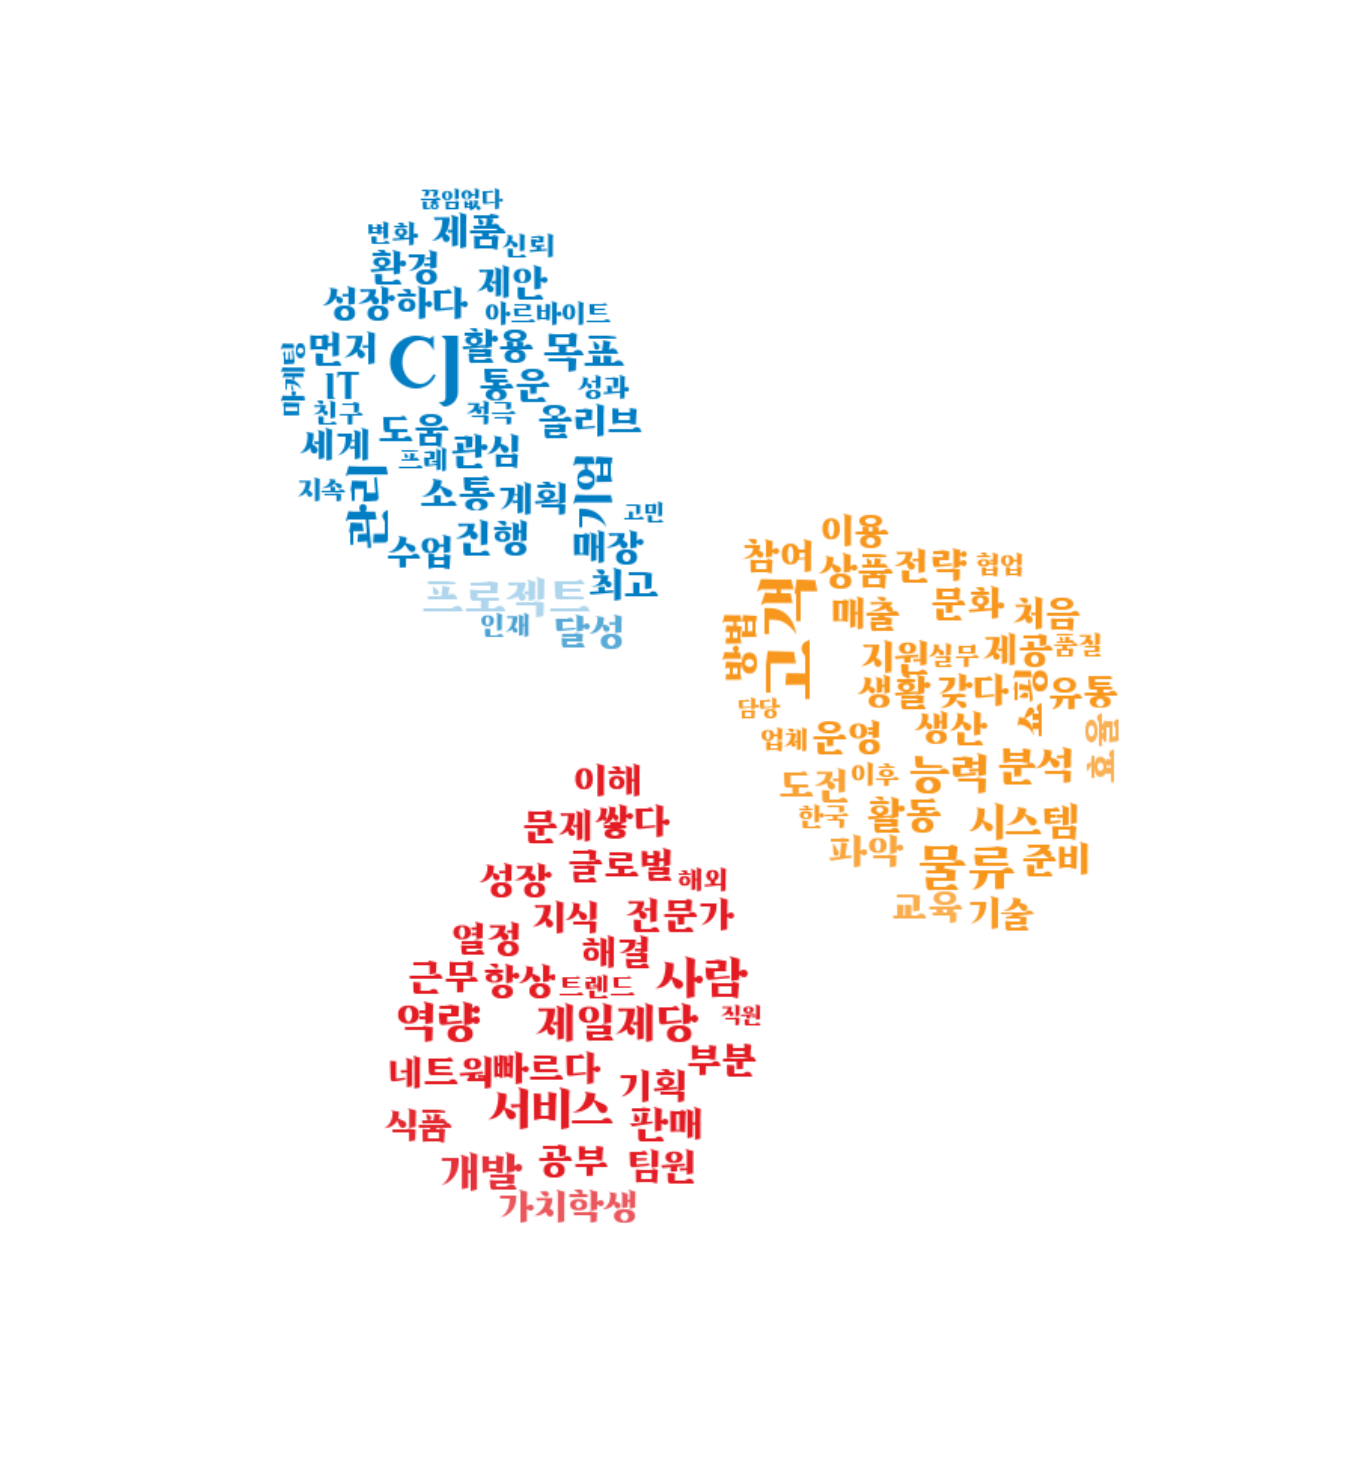

당신은 CJ의 인재상에 가깝습니다!
당신의 자기소개서 점수는 5점 만점에 2.0점 입니다!


In [29]:
company = company_code_dict[similar_company_id] #가장 유사한 자기소개서의 기업(대표)의 이름
make_word_cloud(f'{company}.png', f'{company}_wc', counter_token[similar_company_id]) # 가장 유사한 기업(대표)의 워드클라우드
user_score = test_df["score"][max_idx] # 가장 유사한 자기소개서의 점수로 할당
print(f'당신은 {company}의 인재상에 가깝습니다!')
print(f'당신의 자기소개서 점수는 5점 만점에 {user_score}점 입니다!')

In [30]:
#지원한 직무와 일치하면서 가장 유사한 기업의 자기소개서 데이터프레임 만들기
temp_company_df = test_df[(test_df["company_id"] == similar_company_id) & (test_df["position_broad"] == user_position)]
similar_company_top = temp_company_df.sort_values(["score"], ascending = False).head(5) #가장 높은 점수로 정렬
similar_company_top.reset_index(inplace = True) # for문을 인덱스로 접근하기위해 인덱스 리셋

In [31]:
for idx in similar_company_top.index: # top5 자기소개서 보여주기
    top_score = similar_company_top["score"][idx] # 상위 자기소개서가 받은 점수
    top_company_name = similar_company_top["company"][idx] # 상위 자기소개서의 합격 기업(계열사이름)
    top_company_position = similar_company_top["position"][idx] # 상위 자기소개서의 지원 직무 (소분류)
    if idx == 0:
        print("\n당신과 가까운 인재상을 가진 기업의 자기소개서 상위 5개 입니다.\n\n")
        print(f'[{idx + 1}위]\n')
        print(f'점수 : 5점 만점에 {top_score}점')
        print(f'합격 회사 : {company}그룹의 {top_company_name}')
        print(f'지원 직무: {top_company_position}\n')
        print(similar_company_top["content"][idx] + "\n\n\n") #자기소개서 내용
    else:
        print(f'[{idx + 1}위]\n')
        print(f'점수 : 5점 만점에 {top_score}점')
        print(f'합격 기업 {company}그룹의 {top_company_name}')
        print(f'지원 직무: {top_company_position}\n')
        print(similar_company_top["content"][idx] + "\n\n\n") #자기소개서 내용
        print()


당신과 가까운 인재상을 가진 기업의 자기소개서 상위 5개 입니다.


[1위]

점수 : 5점 만점에 5.0점
합격 회사 : CJ그룹의 CJ프레시웨이㈜
지원 직무: 인사·노무·교육

[CJ프레시웨이와 인재를 이어주는 연결고리] 제가 CJ프레시웨이 인사 직무에 지원한 이유는 단순한 식음 문화가 아닌 휴식 문화로 대한민국 급식문화를 바꾸고 있는 CJ프레시웨이에서 인재 확보로 성장동력을 공급하는 인사 전문가가 되고 싶기 때문입니다. CJ프레시웨이가 시스코와 같은 글로벌 식자재 유통 전문기업으로 성장할 수 있도록 해외 시장 전문가, 무역 비즈니스 전문가, 거래처 대상 영업 컨설턴트 등 각 분야의 능력 있는 인재들을 확보하고, 동시에 이들의 이직을 방지하는 인사 제도 운용으로 CJ프레시웨이의 역량을 높이겠습니다. 이를 위해 다음과 같은 역량을 준비하였습니다. 1. 글로벌 경영학과에서 다국적 기업들의 경영 사례를 회계, 재무, 인사, 조직, 통계 등의 종합적 기법을 다루어 해결하는 ‘I-CORE 프로그램’을 통해 경영 전반의 종합적 역량을 갖추었습니다. 2. 한국생산성본부에서 대학취업프로그램과 본부 내 공개교육 과정을 운영하며 재무, CS 부서 등 각 기업의 부서에서 어떤 인재를 원하고 어떤 역량을 원하는지, 선발된 인재들에게 시행되는 OJT, Off-JT 교육이 어떻게 계획되고 운영되는지를 파악하였습니다. 3. 계량경제학, 경영정보학 등을 수강하며 방대한 자료에서 유의미한 데이터를 산출하는 법을 익혔습니다. 각 지원자의 역량을 계량화하여 올바른 기준과 정보로 CJ프레시웨이의 채용에 기여하겠습니다.  종합적 역량을 갖춘 인사 전문가가 되기 위해 준비한 저의 목표 세 가지는 다음과 같습니다. 1. 7년 뒤 CJ프레시웨이의 채용 전반 프로세스와 인력 운영 체계를 운영하는 채용전문가가 되겠습니다. 각 부서와 소통하며 직무별 필요한 역량을 파악하여 실무와 긴밀히 연계된 채용을 시행하겠습니다.  2. 14년 뒤 임직원이 역량을 최대한 발휘할 수 있도록 공정한 평가 및 보상제도를



[5위]

점수 : 5점 만점에 3.0점
합격 기업 CJ그룹의 CJ대한통운(주)
지원 직무: 재무·세무·IR

숫자 다루는 것에 관심이 많아 이를 잘 살릴 수 있는 회계를 전공했고, 회사가 어떤 성과를 내왔고 향후 중장기적으로 어떻게 사업을 계획해야 하는 지에 대해 회계가 중요한 역할을 한다는 것에 매력을 느꼈습니다. 소규모 NGO단체에서 재무팀장으로 재정을 관리하며 비용 최소화, 후원자에 대한 투명한 정보공개 (결산 등)에 대해 기존의 부적절한 프로세스를 개선하여 성공적으로 목적을 달성했던 경험이 있습니다. 비록 소규모 단체였지만 6개월 간 재정을 총괄하며 책임감을 느꼈고 더 큰 곳에서 책임감을 가지는 자리에 오르고 싶다는 목표를 가졌습니다. 이에 유통 분야 다양한 사업부문에서 기회를 잘 잡고, 위협요인에 대한 올바른 대비를 통해 글로벌 선도기업으로 발전해가는 곳에서 제 꿈을 펼치고 싶습니다. CJ대한통운이 바로 그곳이라 생각하며 저 또한 당사처럼 스스로를 성장시켜 목표에 도달하기 위해 같이의 가치로 함께 성장해가겠습니다.  입사 후 제가 맡은 업무에 대해서만큼은 '전문가'가 되겠습니다. 업무를 하며 선배들이 자신의 업무에 대해 A부터 Z까지 설명하고 그에 관한 의견을 자유롭게 개진하는 것을 보면서 저런 사원이 되어야겠다고 생각해왔습니다. 그러기 위해 항상 배우는 '인재'가 되겠습니다. 자격증을 공부하며 배웠던 이론과 지식들이 실제 현업에서는 어떻게 활용되는지 빠르게 이해하고 부족한 부분에 대해 항상 공부할 것입니다. 저는 최종적으로 CFO가 되어 원활한 혈액순환을 이루고 가치창출의 기회를 탐색하는 것을 목표로 하고 있습니다. 그러한 목표를 위해 현실에 안주하지 않는 '인재'가 되고 싶습니다. 재경 분야는 아는 만큼 보인다고 생각합니다. 직급이 올라감에 따라 업무 범위도 넓어지고 책임의 깊이가 생기는 만큼 현실에 안주해서는 도태되게 됩니다. 입사 후 여가시간을 활용하여 재무, 회계, 세무에 대한 지속된 공부를 통해 자격증이나 심화학위과정을 취득하고 변화하